In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import cv
from catboost import datasets, metrics
from sklearn import metrics
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [169]:
data = pd.read_csv('gepatit.csv', sep=',')
data

,group,toxicant,time,Casp7,Chek,Gclc,Gstm1,Gstp1,Gstt1,Hmox,Nfe2l2,Nqo1,Ripk,Sod1,Apoptoz
0,0,1,1,0.95,1.32,-1.25,0.73,2.28,-1.21,1.29,0.51,-0.93,0.500,-0.90,2.375
1,0,1,1,0.04,0.52,-0.61,0.24,-0.11,1.76,-0.18,-0.92,-0.97,0.650,0.74,3.287
2,0,1,1,-0.73,-0.87,-0.20,-0.39,-1.04,-0.11,0.30,0.31,-0.56,-0.320,0.43,2.347
3,0,1,1,0.87,0.42,0.10,0.80,-0.33,-0.98,0.23,1.05,-0.71,0.340,0.01,2.316
4,0,1,1,-0.29,0.03,1.87,-0.40,1.09,-0.36,-1.39,0.28,0.21,1.330,-0.43,2.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,4,3,2,-0.97,-0.40,-0.27,-1.18,-2.74,-1.75,-1.33,-0.99,0.02,-1.860,-2.96,1.341
206,4,3,2,-0.46,0.49,1.50,1.59,3.18,0.68,0.93,0.43,1.07,-0.958,-1.86,1.818
207,4,3,2,0.64,0.32,3.60,-1.13,-1.49,-1.89,-1.07,-0.95,-0.27,-1.000,-2.79,1.826
208,4,3,2,-1.08,0.03,0.01,-0.93,-1.45,0.68,-1.37,-1.02,0.55,-1.300,-3.29,2.046


In [170]:
X = data.loc[:,'Casp7':'Sod1']
y = data['toxicant']
y[y==1] = 0
y[y==2] = 1
y[y==3] = 2
# y[y==2] = 0
# y[y==3] = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [171]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

In [172]:
xgb_param_grid = {
     'max_depth': [4],
     'learning_rate': [ 0.02],
     'n_estimators': [300], 
     'min_child_weight': [2],
     'scale_pos_weight': [0.2],
     'subsample': [0.8],  
     'colsample_bytree': [0.5],
     'colsample_bylevel': [0.8], 
     'reg_alpha': [0.11],  
     'reg_lambda': [0.05], 
     'max_delta_step': [1],    
     'gamma': [0]
}

In [173]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(random_state=0)

# Find the best hyperparameters
xgb_opt = tune_hyperparameters(xgb, xgb_param_grid, X_train, y_train)


[23:41:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Best hyperparameters:
 {'colsample_bylevel': 0.8, 'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'reg_alpha': 0.11, 'reg_lambda': 0.05, 'scale_pos_weight': 0.2, 'subsample': 0.8}


In [174]:
model_result = pd.DataFrame({'Name': [],
                             'toxic' : [],
                             'AUC': [],
                             })

<Figure size 640x480 with 0 Axes>

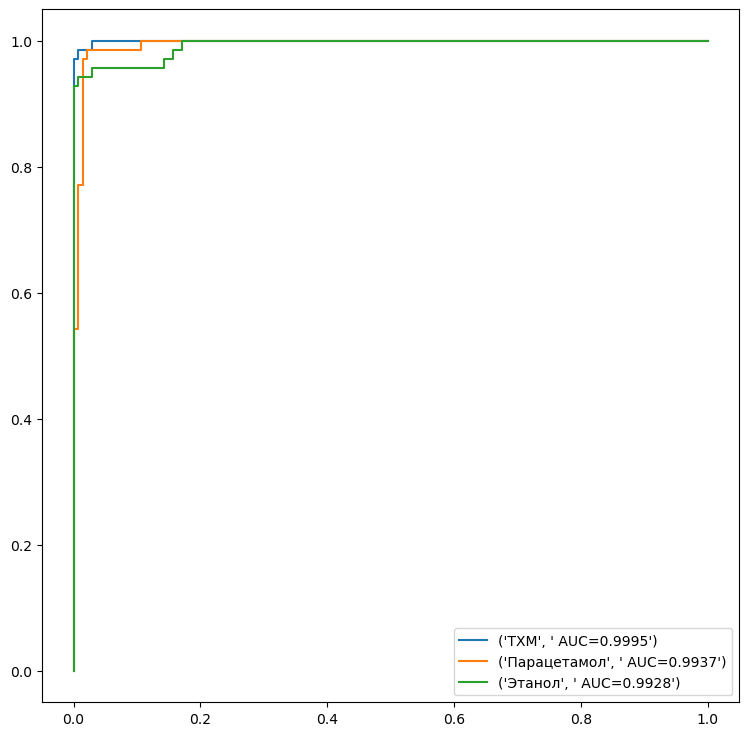

In [175]:
plt.figure(0).clf ();
plt.figure(figsize=(9, 9));
y_pred1 = []
y_pred2 = []
y_pred3 = []
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()

y_pred = xgb_opt.predict_proba(X)
for i in y_pred:
    y_pred1.append(i[0])
    y_pred2.append(i[1])
    y_pred3.append(i[2])

y1[y1 == 1] = 3
y1[y1 == 2] = 3
y1[y1 == 0] = 1
y1[y1 == 3] = 0

y2[y2 == 0] = 0
y2[y2 == 1] = 1
y2[y2 == 2] = 0

y3[y3 == 0] = 0
y3[y3 == 1] = 0
y3[y3 == 2] = 1

fpr, tpr, _ = metrics.roc_curve (y1, y_pred1)
auc = round(metrics.roc_auc_score (y1, y_pred1), 4)
plt.plot (fpr,tpr,label=('ТХМ', " AUC="+str(auc)))
model_result.loc[ len(model_result.index)] = ['XGBoost', 'ТХМ', auc]

fpr, tpr, _ = metrics.roc_curve (y2, y_pred2)
auc = round(metrics.roc_auc_score (y2, y_pred2), 4)
plt.plot (fpr,tpr,label=('Парацетамол', " AUC="+str(auc)))
model_result.loc[ len(model_result.index)] = ['XGBoost', 'Парацетамол', auc]

fpr, tpr, _ = metrics.roc_curve (y3, y_pred3)
auc = round(metrics.roc_auc_score (y3, y_pred3), 4)
plt.plot (fpr,tpr,label=('Этанол', " AUC="+str(auc)))
plt.legend()
model_result.loc[ len(model_result.index)] = ['XGBoost', 'Этанол', auc];

In [178]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.01, n_estimators=1000)
clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=1000)

<Figure size 640x480 with 0 Axes>

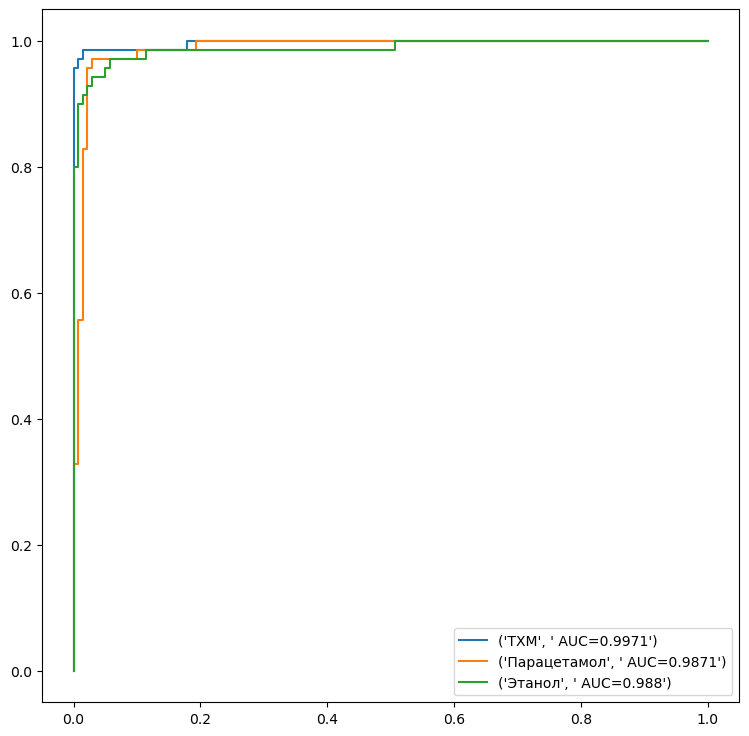

In [179]:
plt.figure(0).clf ();
plt.figure(figsize=(9, 9));
y_pred1 = []
y_pred2 = []
y_pred3 = []
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()

y_pred = clf.predict_proba(X)
for i in y_pred:
    y_pred1.append(i[0])
    y_pred2.append(i[1])
    y_pred3.append(i[2])

y1[y1 == 1] = 3
y1[y1 == 2] = 3
y1[y1 == 0] = 1
y1[y1 == 3] = 0

y2[y2 == 0] = 0
y2[y2 == 1] = 1
y2[y2 == 2] = 0

y3[y3 == 0] = 0
y3[y3 == 1] = 0
y3[y3 == 2] = 1

fpr, tpr, _ = metrics.roc_curve (y1, y_pred1)
auc = round(metrics.roc_auc_score (y1, y_pred1), 4)
plt.plot (fpr,tpr,label=('ТХМ', " AUC="+str(auc)))
model_result.loc[ len(model_result.index)] = ['LightGBM', 'ТХМ', auc]

fpr, tpr, _ = metrics.roc_curve (y2, y_pred2)
auc = round(metrics.roc_auc_score (y2, y_pred2), 4)
plt.plot (fpr,tpr,label=('Парацетамол', " AUC="+str(auc)))
model_result.loc[ len(model_result.index)] = ['LightGBM', 'Парацетамол', auc]

fpr, tpr, _ = metrics.roc_curve (y3, y_pred3)
auc = round(metrics.roc_auc_score (y3, y_pred3), 4)
plt.plot (fpr,tpr,label=('Этанол', " AUC="+str(auc)))
plt.legend()
model_result.loc[ len(model_result.index)] = ['LightGBM', 'Этанол', auc];

In [180]:
cat_features = []
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=2000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6,
    custom_loss=['AUC', 'Accuracy']
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    eval_set=(X_test, y_test),
    plot=True
)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<Figure size 640x480 with 0 Axes>

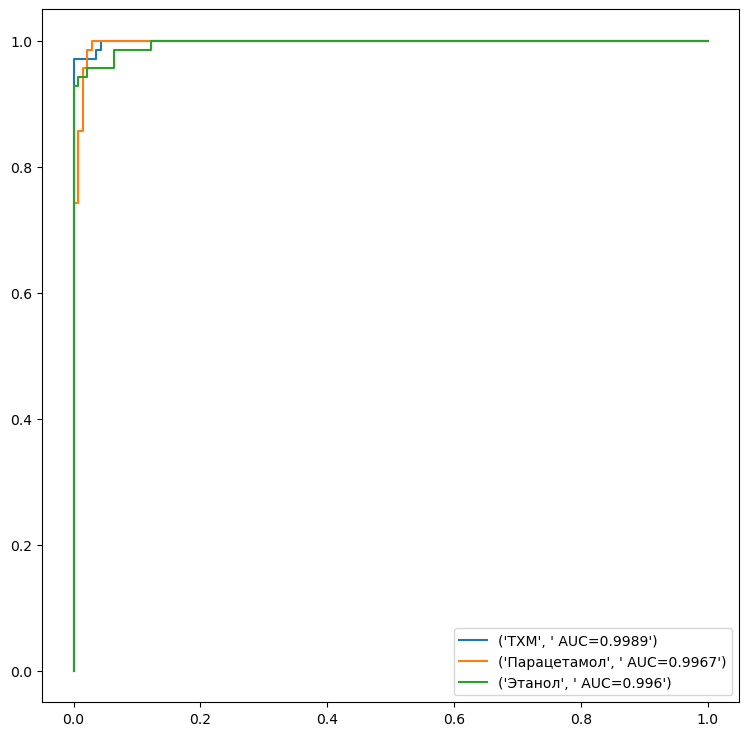

In [181]:
plt.figure(0).clf ();
plt.figure(figsize=(9, 9));
y_pred1 = []
y_pred2 = []
y_pred3 = []
y1 = y.copy()
y2 = y.copy()
y3 = y.copy()

y_pred = tunned_model.predict_proba(X)
for i in y_pred:
    y_pred1.append(i[0])
    y_pred2.append(i[1])
    y_pred3.append(i[2])


y1[y1 == 1] = 3
y1[y1 == 2] = 3
y1[y1 == 0] = 1
y1[y1 == 3] = 0

y2[y2 == 0] = 0
y2[y2 == 1] = 1
y2[y2 == 2] = 0

y3[y3 == 0] = 0
y3[y3 == 1] = 0
y3[y3 == 2] = 1

fpr, tpr, _ = metrics.roc_curve (y1, y_pred1)
auc = round(metrics.roc_auc_score (y1, y_pred1), 4)
plt.plot (fpr,tpr,label=('ТХМ', " AUC="+str(auc)))
model_result.loc[ len(model_result.index)] = ['CatBoost', 'ТХМ', auc]

fpr, tpr, _ = metrics.roc_curve (y2, y_pred2)
auc = round(metrics.roc_auc_score (y2, y_pred2), 4)
plt.plot (fpr,tpr,label=('Парацетамол', " AUC="+str(auc)))
model_result.loc[ len(model_result.index)] = ['CatBoost', 'Парацетамол', auc]

fpr, tpr, _ = metrics.roc_curve (y3, y_pred3)
auc = round(metrics.roc_auc_score (y3, y_pred3), 4)
plt.plot (fpr,tpr,label=('Этанол', " AUC="+str(auc)))
plt.legend()
model_result.loc[ len(model_result.index)] = ['CatBoost', 'Этанол', auc];

In [182]:
model_result

,Name,toxic,AUC
0,XGBoost,ТХМ,0.9995
1,XGBoost,Парацетамол,0.9937
2,XGBoost,Этанол,0.9928
3,LightGBM,ТХМ,0.9971
4,LightGBM,Парацетамол,0.9871
5,LightGBM,Этанол,0.9880
6,CatBoost,ТХМ,0.9989
7,CatBoost,Парацетамол,0.9967
8,CatBoost,Этанол,0.9960


In [163]:
y4=y
y4[y4 == 2] = 3
y4[y4 == 1] = 3
y4[y4 == 0] = 1
y4[y4 == 3] = 0
y4.unique()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([1, 0], dtype=int64)

In [164]:
model2 = CatBoostClassifier(
    random_seed=63,
    iterations=2000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    depth=6,
    custom_loss=['AUC', 'Accuracy']
)
model2.fit(
    X, y4,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6649753	total: 2.68ms	remaining: 5.37s
50:	learn: 0.1892929	total: 93.8ms	remaining: 3.58s
100:	learn: 0.1008830	total: 175ms	remaining: 3.29s
150:	learn: 0.0623225	total: 266ms	remaining: 3.25s
200:	learn: 0.0400961	total: 335ms	remaining: 2.99s
250:	learn: 0.0260741	total: 401ms	remaining: 2.79s
300:	learn: 0.0183282	total: 471ms	remaining: 2.66s
350:	learn: 0.0138688	total: 553ms	remaining: 2.6s
400:	learn: 0.0112379	total: 632ms	remaining: 2.52s
450:	learn: 0.0091971	total: 709ms	remaining: 2.43s
500:	learn: 0.0078609	total: 785ms	remaining: 2.35s
550:	learn: 0.0068738	total: 851ms	remaining: 2.24s
600:	learn: 0.0060668	total: 916ms	remaining: 2.13s
650:	learn: 0.0054575	total: 980ms	remaining: 2.03s
700:	learn: 0.0049380	total: 1.04s	remaining: 1.94s
750:	learn: 0.0045208	total: 1.11s	remaining: 1.85s
800:	learn: 0.0041895	total: 1.18s	remaining: 1.77s
850:	learn: 0.0038609	total: 1.25s	remaining: 1.69s
900:	learn: 0.0035871	total: 1.32s	remaining: 1.61s
950:	learn: 0.

In [135]:
pool1 = Pool(data=X, label=y4, cat_features=cat_features)
shap_info = model2.get_feature_importance(data=pool1, type='ShapValues', verbose=10000)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
print(shap_values.shape)

Processing trees...
128/2000 trees processed	passed time: 73.8ms	remaining time: 1.08s
2000/2000 trees processed	passed time: 741ms	remaining time: 0us
Processing documents...
128/210 documents processed	passed time: 12.5ms	remaining time: 8ms
210/210 documents processed	passed time: 20.1ms	remaining time: 0us
(210, 11)


In [136]:
X.iloc[0:1]

,Casp7,Chek,Gclc,Gstm1,Gstp1,Gstt1,Hmox,Nfe2l2,Nqo1,Ripk,Sod1
0,0.95,1.32,-1.25,0.73,2.28,-1.21,1.29,0.51,-0.93,0.5,-0.9


In [137]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model2.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model2.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9964
Formula raw prediction = 5.6327




In [138]:
import shap
i = 20
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [139]:
i = 50
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [140]:
i = 100
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [141]:
i = 100
shap.initjs()
shap.force_plot(base_value=base_values[i], shap_values=shap_values[i], features=X.iloc[i])

In [142]:
explainer = shap.TreeExplainer(model2)
shap_values=explainer.shap_values(Pool(X, y, cat_features=cat_features))

In [143]:
shap.force_plot(explainer.expected_value, shap_values, X)

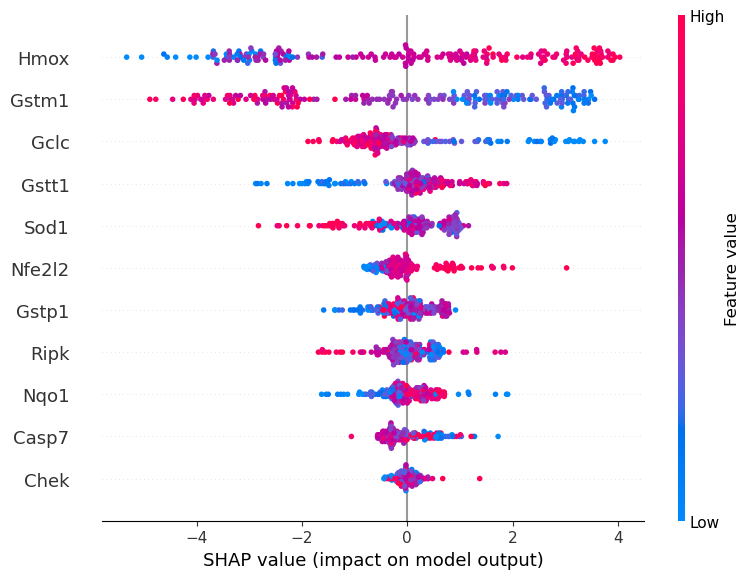

In [184]:
tree_explainer = shap.TreeExplainer(model2)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)